## 1. 히스토그램 역투영(Histogram backprojection)

- 기준 영상의 히스토그램 정보를 이용하여 입력 영상에서 찾고자 하는 물체를 검출하는 방법
- 물체의 모양은 무시하고 단순히 컬러 분포만으로 검출하는 방법
- 히스토그램을 매핑 함수로 사용하여, 화소 값을 신뢰도 값으로 변환

## 예) 피부색 영역 검출하기
- RGB 색상 공간 => HSL(또는 HLS) 색상 공간으로 변환
  - H(Hue): 색상
  - S(Saturation): 채도
  - L(Lightness): 밝기
<img src='rc/HSL.png' alt='HSL' width="400" heigh="400">

- 밝기(L)는 조명에 따라 쉽게 변할 뿐만 아니라 피부와 비슷한 밝기를 갖는 다른 영역이 여러 군데 존재할 가능성이 높음
- 따라서, 밝기(L)는 무시하고 색상(H)과 채도(S)를 사용함

# 2. 수행 과정

<img src='rc/2d histogram.png' alt='2d histogram' width="800" heigh="600">  

- 기준 영상 $m$에서 구한 히스토그램 $h_m$을 어떤 화소 값이 피부에 해당하는지에 대한 신뢰도 값으로 변환해주는 함수로 사용함
- 새로운 입력 영상 $i$가 주어지면 $h_m$을 이용하여 피부색 영역 검출
- 실제로는 $h_m$ 대신 비율 히스토그램 $h_r$을 사용함

$$
h_{r}(i,j)=min(\frac{\hat{h_m}(i,j)}{\hat{h_i}(i,j)}, 1.0)
$$

<img src='rc/histogram backprojection.png' alt='histogram backprojection' width="800" heigh="600">  

- 결과

<img src='rc/result.png' alt='result' width="600" heigh="600">  


# 3. 장단점

- 한계
  - 비슷한 색 분포를 갖는 다른 물체를 구별 못함
  - 검출 대상이 여러 색 분포를 갖는 경우 여러 개의 모델을 사용해야 하므로 오류 가능성을 높아짐
  - 특히 피부색 검출의 경우 인종에 따라 결과가 달라짐
  - 따라서, 컴퓨터 비전 분야에서는 물체 검출 문제를 풀 때 **모양 특징을 주로 사용**하며, 상황에 따라 **색 정보를 보조적으로 사용함**
  
<br>  

- 장점
  - 물체의 이동이나 회전이 발생하더라도 히스토그램은 불변하므로 성능이 유지됨
  - 물체의 일부가 가려진 경우에도 어느 정도 작동함
  - 따라서, 배경의 색 분포가 균일하면서 물체의 색 분포와 겹치지 않는 경우에 유용함


### [reference]  
  - image - https://github.com/sunkyoo/opencv4cvml/tree/master/ch10/backproj
  [](https://theailearner.com/2019/04/18/histogram-backprojection/)

# 4. Practice
## 1) 기준 영상 정보 확인

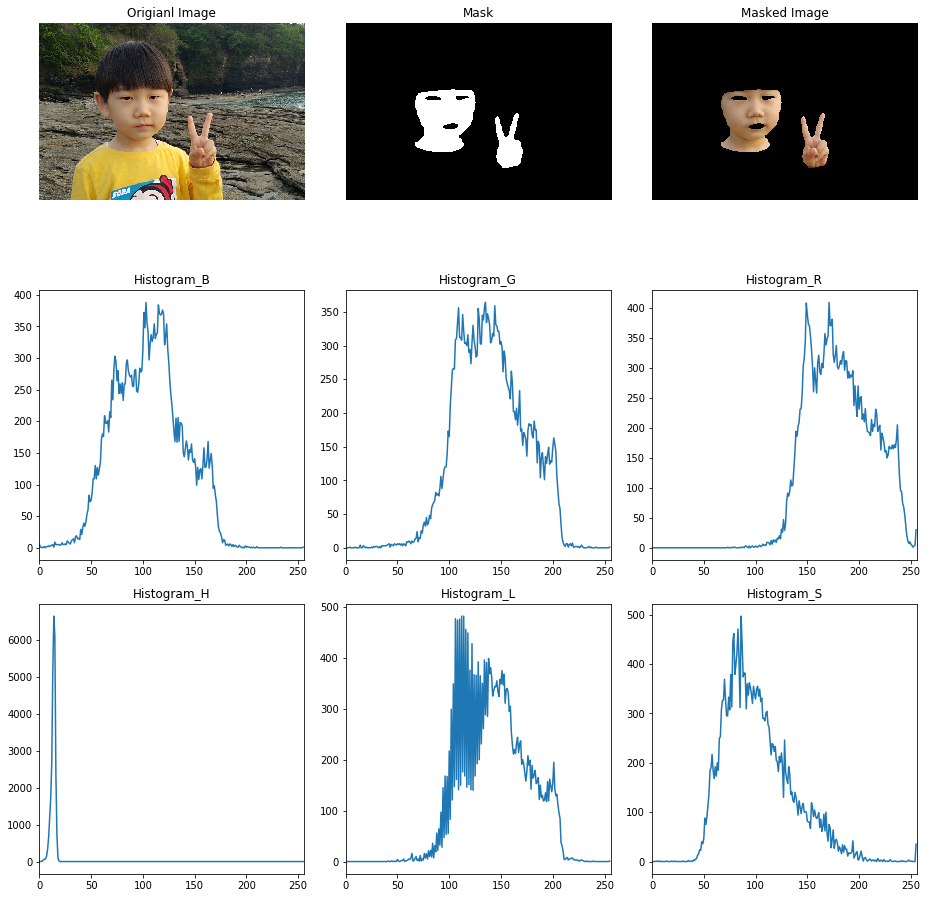

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# 기준 영상 읽어오기
img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)  #파일을 grayscale로 읽음
masked_img = cv2.bitwise_and(img_m, img_m, mask=mask) #mask에 있는 부분만 가져오고 싶을때 

# 기준 영상의 R,G,B 채널 히스토그램 계산
hist_b = cv2.calcHist([img_m], [0], mask, [256], [0,256])  #영상을 리스트 배열안에 넣어줘야함, x축의 갯수, 범위
hist_g = cv2.calcHist([img_m], [1], mask, [256], [0,256])
hist_r = cv2.calcHist([img_m], [2], mask, [256], [0,256])

# RGB -> HSL 변환
hls_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)

# 기준 영상의 H,S,L 채널 히스토그램 계산
hist_h = cv2.calcHist([hls_m], [0], mask, [256], [0,256])
hist_l = cv2.calcHist([hls_m], [1], mask, [256], [0,256])
hist_s = cv2.calcHist([hls_m], [2], mask, [256], [0,256])

# 기준 영상 및 히스토그램 시각화
plt.figure(figsize=(13, 13))

# cv2.cvtColor(img_m, cv2.COLOR_BGR2RGB)
plt.subplot(331), plt.imshow(img_m[...,::-1]), plt.title('Origianl Image'), plt.axis('off')
plt.subplot(332), plt.imshow(mask,'gray'), plt.title('Mask'), plt.axis('off')
plt.subplot(333), plt.imshow(masked_img[...,::-1]), plt.title('Masked Image'), plt.axis('off')

plt.subplot(334), plt.plot(hist_b), plt.title('Histogram_B'), plt.xlim([0,256])
plt.subplot(335), plt.plot(hist_g), plt.title('Histogram_G'), plt.xlim([0,256])
plt.subplot(336), plt.plot(hist_r), plt.title('Histogram_R'), plt.xlim([0,256])

plt.subplot(337), plt.plot(hist_h), plt.title('Histogram_H'), plt.xlim([0,256])
plt.subplot(338), plt.plot(hist_l), plt.title('Histogram_L'), plt.xlim([0,256])
plt.subplot(339), plt.plot(hist_s), plt.title('Histogram_S'), plt.xlim([0,256])

plt.tight_layout()
plt.show()

## 2) 히스토그램 역투영

In [60]:
import cv2
import numpy as np

# 기준 영상 불러오기
img_m = cv2.imread('model.png')
mask = cv2.imread('mask.bmp', cv2.IMREAD_GRAYSCALE)

## 기준 영상의 H-S 히스토그램 생성
hls_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2HLS)
hist_m = cv2.calcHist([hls_m], [0,2], mask, [181,256], [0,181,0,256]) #인덱스가 0이면 Hue, 2이면 Saturation

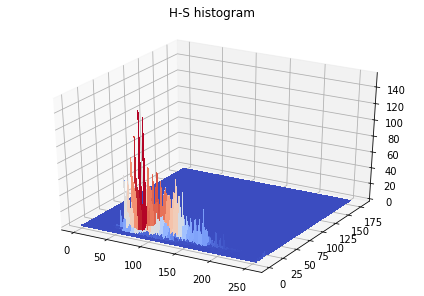

In [61]:
## 기준 영상 피부색 영역 2차원 히스토그램 시각화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_m, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()


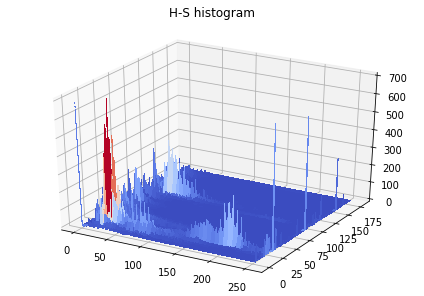

In [62]:
## 입력 영상 2차원 히스토그램 시각화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

img_i = cv2.imread('test.png')
hls_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2HLS)  #test이미지를 HLS영상으로 변환한 것, 3차원 배열

hist_i = cv2.calcHist([hls_i], [0,2], None, [181,256], [0,181,0,256])  
#Hue가 원래는 360도로 표현되지만 cv2모듈에서는 0부터 180까지의 값을 사용하기 때문에 범위를 181로 함
# 입력영상은 hls_i, 이중 H와 S 만 사용, 이미지 전체영역 분석, 계산영역 지정(181,256), 계산결과 저장

hist_i = np.minimum(hist_i, 700)  #hist_i와 700 중 최소값을 저장함(빈도수 최대값을 700으로 설정)

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_i, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('H-S histogram')
plt.show()


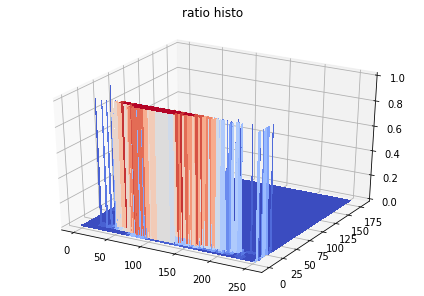

In [79]:
## 입력 이미지의 H-S 히스토그램 계산
img_i = cv2.imread('test.png')  #입력영상
hls_i = cv2.cvtColor(img_i, cv2.COLOR_BGR2HLS)  #입력영상을 HLS로 변환
hist_i = cv2.calcHist([hls_i], [0,2], None, [181,256], [0,181,0,256])


# 히스토그램 정규화
hist_m = (hist_m - hist_m.min()) / (hist_m.max()-hist_m.min())
hist_i = (hist_i - hist_i.min()) / (hist_i.max()-hist_i.min())


## 비율 히스토그램 구하기
# hist_r=np.minimum(hist_m/(hist_i+0.000000001), 1.0)
hist_ratio=np.zeros((181, 256))

for i in range(0, 181):
    for j in range(0,256):
#         if(hist_i[i][j]==0):
#             hist_ratio[i][j]=0 
        hist_ratio=np.minimum(hist_m/(hist_i+0.000000001), 1.0)            
            

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(256)
Y = np.arange(181)
X,Y = np.meshgrid(X,Y)

surf = ax.plot_surface(X,Y,hist_ratio, cmap='coolwarm', linewidth=0, antialiased=False)

fig.tight_layout()
plt.title('ratio histo')
plt.show()

In [80]:
##역투영 사상하기


print("===========입력영상===========")
print(np.shape(hls_i))
print(np.shape(hls_i[0]))  #Hue
print(np.shape(hls_i[2]))  #Saturation

answer_h=np.zeros((480, 720))
answer_s=np.zeros((480, 720))
for i in range(480):
    for j in range(720):
        answer_h[i][j]=hls_i[i][j][0]  #hue부분 복사
        answer_s[i][j]=hls_i[i][j][2]  #saturation부분 복사

print("\n========H, S만 넣은 배열=========")
print(np.shape(answer_h))
print(np.shape(answer_s))
print(type(answer_h))
num=answer_h[0][0]
print(type(int(num)))

answer=np.zeros((480,720))
for i in range(480):
    for j in range(720):
        a=int(answer_h[i][j])
        b=int(answer_s[i][j])
        answer[i][j]=hist_ratio[a][b]


===========입력영상===========
(480, 720, 3)
(720, 3)
(720, 3)

========H, S만 넣은 배열=========
(480, 720)
(480, 720)
<class 'numpy.ndarray'>
<class 'int'>


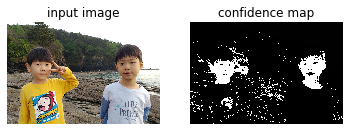

In [4]:
## 결과 시각화

plt.subplot(1,2,1)
plt.imshow(img_i[...,::-1])
plt.axis('off')
plt.title('input image')

plt.subplot(1,2,2)
plt.imshow(result,'gray')
plt.axis('off')
plt.title('confidence map')

plt.show()

## 3) 모폴로지 연산을 통한 개선

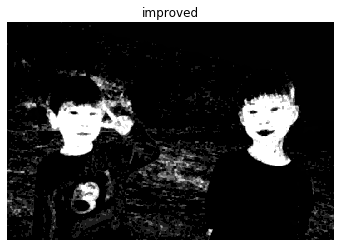

In [5]:
## 모폴로지 연산 적용
'''
To do
opencv2 에서 제공하는 함수 이용하기
opening=erosion->dilation: 흰색 노이즈 없애기
closing=dilation->erosion: 작은 검은색 구멍 메우기
'''
kernel1=np.ones((3,3), np.uint8)
gaussian=cv2.blur(result, (3,3))

improved = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, kernel1)
improved = cv2.morphologyEx(improved, cv2.MORPH_CLOSE, kernel1)


plt.imshow(improved, 'gray')
plt.axis('off')
plt.title('improved')

plt.show()

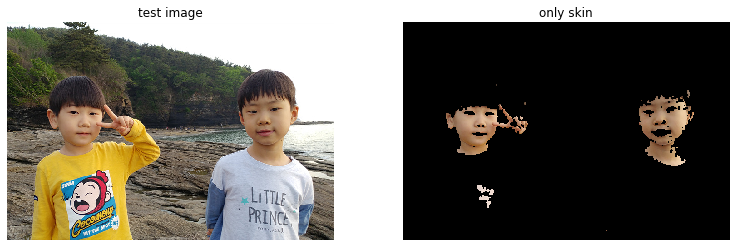

In [6]:
## 피부색 영역 검출
skin = cv2.bitwise_and(img_i, img_i, mask=improved.astype('uint8'))

plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.imshow(img_i[...,::-1])
plt.axis('off')
plt.title('test image')

plt.subplot(1,2,2)
plt.imshow(skin[...,::-1])
plt.axis('off')
plt.title('only skin')

plt.show()